# MLR: Assumptions, Model Diagnostics, and Model Evaluation

#### Author: Kunyu He, CAPP'20

## 0. Preparation

In [1]:
import sys

sys.path.append("../../codes/")

In [18]:
from warnings import simplefilter

simplefilter(action='ignore', category=(FutureWarning, UserWarning))

In [75]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pylab
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import jarque_bera, probplot
from sklearn.datasets import load_diabetes
from statsmodels.stats.outliers_influence import variance_inflation_factor
from yellowbrick.regressor import CooksDistance

import utils

In [3]:
df_dict = load_diabetes()
print((df_dict['DESCR']))

.. _diabetes_dataset:

Diabetes dataset
----------------

Ten baseline variables, age, sex, body mass index, average blood
pressure, and six blood serum measurements were obtained for each of n =
442 diabetes patients, as well as the response of interest, a
quantitative measure of disease progression one year after baseline.

**Data Set Characteristics:**

  :Number of Instances: 442

  :Number of Attributes: First 10 columns are numeric predictive values

  :Target: Column 11 is a quantitative measure of disease progression one year after baseline

  :Attribute Information:
      - Age
      - Sex
      - Body mass index
      - Average blood pressure
      - S1
      - S2
      - S3
      - S4
      - S5
      - S6

Note: Each of these 10 feature variables have been mean centered and scaled by the standard deviation times `n_samples` (i.e. the sum of squares of each column totals 1).

Source URL:
https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html

For more information see:
Bra

>Ten baseline variables, age, sex, body mass index, average blood pressure, and six blood serum measurements were obtained for each of n = 442 diabetes patients, as well as the response of interest, a quantitative measure of disease progression one year after baseline ([link](https://www4.stat.ncsu.edu/~boos/var.select/diabetes.html))

In [4]:
X = pd.DataFrame(df_dict['data'], columns=df_dict['feature_names'])
y = df_dict['target']

In [5]:
X.head()

,age,sex,bmi,bp,s1,s2,s3,s4,s5,s6
0,0.038076,0.050680,0.061696,0.021872,-0.044223,-0.034821,-0.043401,-0.002592,0.019908,-0.017646
1,-0.001882,-0.044642,-0.051474,-0.026328,-0.008449,-0.019163,0.074412,-0.039493,-0.068330,-0.092204
2,0.085299,0.050680,0.044451,-0.005671,-0.045599,-0.034194,-0.032356,-0.002592,0.002864,-0.025930
3,-0.089063,-0.044642,-0.011595,-0.036656,0.012191,0.024991,-0.036038,0.034309,0.022692,-0.009362
4,0.005383,-0.044642,-0.036385,0.021872,0.003935,0.015596,0.008142,-0.002592,-0.031991,-0.046641


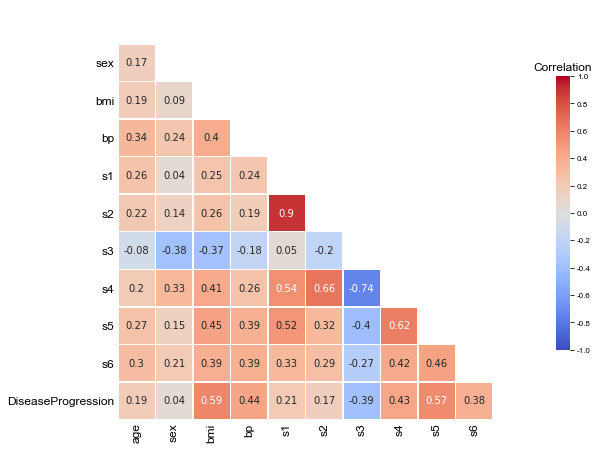

In [6]:
labels = list(X.columns) + ['DiseaseProgression']

fig, ax = plt.subplots(figsize=(9, 8))
utils.corr_plot(ax,
                np.corrcoef(np.c_[X.values, y].T),
                labels=labels,
                triangle=True,
                upper=False,
                annot_size=10)
fig.tight_layout()

In [7]:
X_ = sm.add_constant(X)

model = sm.OLS(y, X_).fit()
print((model.summary()))

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.518
Model:                            OLS   Adj. R-squared:                  0.507
Method:                 Least Squares   F-statistic:                     46.27
Date:                Sat, 04 Apr 2020   Prob (F-statistic):           3.83e-62
Time:                        01:21:29   Log-Likelihood:                -2386.0
No. Observations:                 442   AIC:                             4794.
Df Residuals:                     431   BIC:                             4839.
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        152.1335      2.576     59.061      0.0

## 1. MLR Assumtions and Model Diagnostics

Wooldridge, Introductory Econometrics

### MLR.1 Linear in Parameters

**Population model** can be written as:

$$y=\beta_0+\beta_1x_1+...+\beta_kx_k+\mu$$

where $\beta_0, \beta_1, ..., \beta_k$ are the unknown **parameters** (constants) of interest and $\mu$ is an observed random error or disturbance term.

Note that $y$ and $x_i$ can take any functional form like natural logarithms ($i=1, 2, ..., k$).

#### Testing

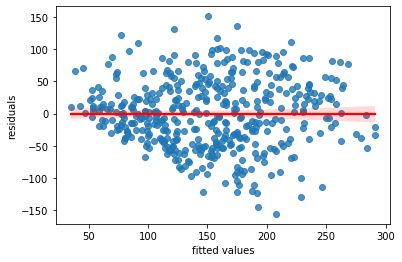

In [8]:
predicted = model.predict(X_)
sns.regplot(x=predicted, y=model.resid, line_kws={'color': "red"})
plt.ylabel("residuals")
plt.xlabel("fitted values")

### MLR. 2 Random Sampling

The sample of n observations is a random sample following the population model.

#### Testing

- Influence:

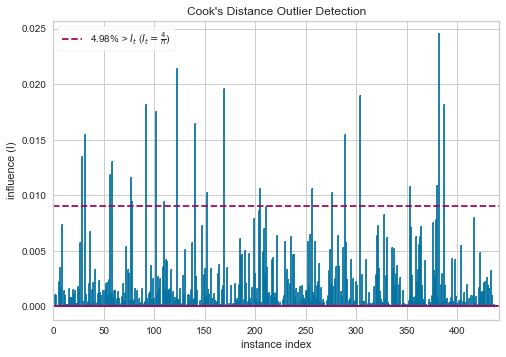

Percentage of outliers: 4.977%


In [25]:
visualizer = CooksDistance()
visualizer.fit(X_, y)
visualizer.show()
print(
    ("Percentage of outliers: {:.3f}%".format(visualizer.outlier_percentage_)))

- Levarage Plot

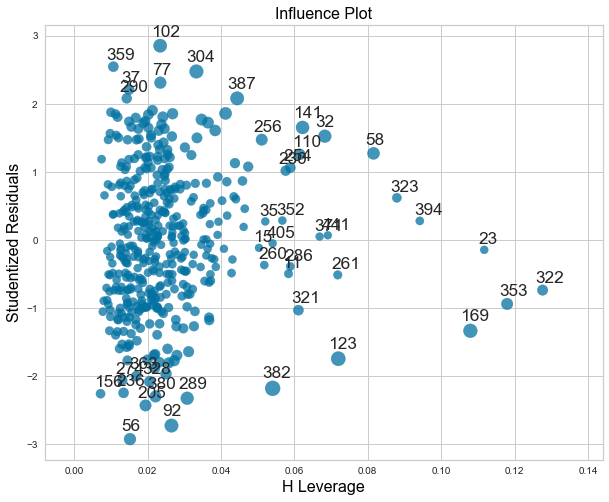

In [36]:
fig, ax = plt.subplots(figsize=(10, 8))
fig = sm.graphics.influence_plot(model, ax=ax, criterion="cooks", size=15)

### MLR. 3 No Perfect Collinearity

In the sample, none of the independent variables is constant and there are no exact linear relationships among the independent variables.

#### Testing:

In [58]:
(X.var(axis=0) == 0).sum()

0

In [59]:
vifs = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
for col, vif in zip(X.columns, vifs):
    print(("%s: %.2f" % (col, vif), ["", "LARGER THAN 10!"][int(vif > 10)]))

age: 1.22 
sex: 1.28 
bmi: 1.51 
bp: 1.46 
s1: 59.20 LARGER THAN 10!
s2: 39.19 LARGER THAN 10!
s3: 15.40 LARGER THAN 10!
s4: 8.89 
s5: 10.08 LARGER THAN 10!
s6: 1.48 


#### Why is multicollinearity harmful?

The illustration on this dataset does not work because perfect collinearity is not likely in practice and Python is not exactly accurate in calculations.

**I'll use a easy to understand R example output to show this.** What I did is essentially getting a new column `PerfectCollinear` as a sum of two columns, `vs` and `am`.

![](r_screenshot.png)

Linear algebra perspective: [Kunyu's blog](https://towardsdatascience.com/ridge-regression-and-multicollinearity-d8a3e06efce8).

### MLR. 4 Zero Conditional Mean

The error $\mu$ has an expected value of zero given any values of the independent variables. In other words,

$$E(\mu|X)=0$$

**UNBIASED ESTIMATES WITH MLR. 1 THROUGH MLR.4**

### MLR 5. Homoskedasticity

The error $\mu$ has the same variance given any value of the explanatory variables. In other words,

$$Var(\mu|X)=\sigma^2$$

**BLUE: LOWEST VARIANCE AMONG ALL UNBIASED ESTIMATES**

### MLR 6. Normality

The population error $\mu$ is independent of the explanatory variables and:

$$\mu \sim N(0, \sigma^2)$$

#### Testing

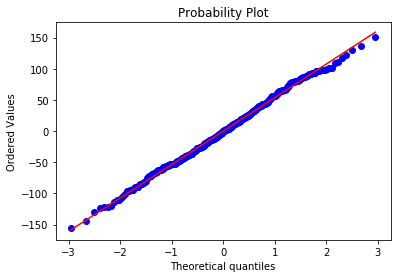

In [40]:
probplot(model.resid, dist='norm', plot=pylab)

In [41]:
jarque_bera(model.resid)

(1.4036025316898297, 0.49569162676119116)

## 2. Model Evaluation